In [21]:
from nutil import *

In [22]:
# Use only the provided packages!
import math
import csv

from collections import Counter

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import learning_curve

In [23]:
######################################################################
# Immutatble classes
######################################################################

class Classifier(object) :
    """
    Classifier interface.
    """

    def fit(self, X, y):
        raise NotImplementedError()

    def predict(self, X):
        raise NotImplementedError()


class MajorityVoteClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that always predicts the majority class.

        Attributes
        --------------------
            prediction_ -- majority class
        """
        self.prediction_ = None

    def fit(self, X, y) :
        """
        Build a majority vote classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """
        majority_val = Counter(y).most_common(1)[0][0]
        self.prediction_ = majority_val
        return self

    def predict(self, X) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.prediction_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")

        n,d = X.shape
        y = [self.prediction_] * n
        return y



In [24]:
######################################################################
# Mutatble classes
######################################################################

class RandomClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that predicts according to the distribution of the classes.

        Attributes
        --------------------
            probabilities_ -- class distribution dict (key = class, val = probability of class)
        """
        self.probabilities_ = None

    def fit(self, X, y) :
        """
        Build a random classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """

        ### ========== TODO : START ========== ###
        # part b: set self.probabilities_ according to the training set
        size = y.size
        self.probabilities_ = {}
        for i in range(0, size):
            class_label = y[i]
            if class_label in self.probabilities_:
                self.probabilities_[class_label] += 1
            else:
                self.probabilities_[class_label] = 1

        for key in self.probabilities_:
            self.probabilities_[key] /= size

        ### ========== TODO : END ========== ###

        return self

    def predict(self, X, seed=1234) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            seed -- integer, random seed

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.probabilities_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")
        np.random.seed(seed)

        ### ========== TODO : START ========== ###
        # part b: predict the class for each test example
        # hint: use np.random.choice (be careful of the parameters)
        unique_classes = np.array(list(self.probabilities_.keys()))
        y = np.random.choice(unique_classes, size=X.shape[0], p=list(self.probabilities_.values()))

        ### ========== TODO : END ========== ###

        return y


In [25]:
######################################################################
# Immutatble functions
######################################################################

def plot_histograms(X, y, Xnames, yname) :
    n,d = X.shape  # n = number of examples, d =  number of features
    fig = plt.figure(figsize=(20,15))
    ncol = 3
    nrow = d // ncol + 1
    for i in range(d) :
        fig.add_subplot (nrow,ncol,i+1)
        data, bins, align, labels = plot_histogram(X[:,i], y, Xname=Xnames[i], yname=yname, show = False)
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xnames[i])
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')

    plt.savefig ('histograms.pdf')


def plot_histogram(X, y, Xname, yname, show = True) :
    """
    Plots histogram of values in X grouped by y.

    Parameters
    --------------------
        X     -- numpy array of shape (n,d), feature values
        y     -- numpy array of shape (n,), target classes
        Xname -- string, name of feature
        yname -- string, name of target
    """

    # set up data for plotting
    targets = sorted(set(y))
    data = []; labels = []
    for target in targets :
        features = [X[i] for i in range(len(y)) if y[i] == target]
        data.append(features)
        labels.append('%s = %s' % (yname, target))

    # set up histogram bins
    features = set(X)
    nfeatures = len(features)
    test_range = list(range(int(math.floor(min(features))), int(math.ceil(max(features)))+1))
    if nfeatures < 10 and sorted(features) == test_range:
        bins = test_range + [test_range[-1] + 1] # add last bin
        align = 'left'
    else :
        bins = 10
        align = 'mid'

    # plot
    if show == True:
        plt.figure()
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xname)
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')
        plt.show()

    return data, bins, align, labels


In [26]:
######################################################################
# Mutatble functions
######################################################################

from sklearn.metrics import f1_score


def error(clf, X, y, ntrials=100, test_size=0.15) :
    """
    Computes the classifier error over a random split of the data,
    averaged over ntrials runs.

    Parameters
    --------------------
        clf         -- classifier
        X           -- numpy array of shape (n,d), features values
        y           -- numpy array of shape (n,), target classes
        ntrials     -- integer, number of trials

    Returns
    --------------------
        train_error -- float, training error
        val_error  -- float, validation error
        f1_score    -- float, validation "micro" averaged f1 score
    """

    ### ========== TODO : START ========== ###
    # part f:
    # compute cross-validation error using StratifiedShuffleSplit over ntrials
    # hint: use StratifiedShuffleSplit (be careful of the parameters)
    train_errors = []
    val_errors = []
    f1_scores = []

    # Set random_state for reproducibility
    random_state = 0

    for _ in range(ntrials):
        # Create a StratifiedShuffleSplit object
        sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=50)

        for train_index, test_index in sss.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Fit the classifier on the training data
            clf.fit(X_train, y_train)

            # Predict on the training and validation sets
            y_train_pred = clf.predict(X_train)
            y_val_pred = clf.predict(X_test)

            # Calculate training and validation errors
            train_error = 1 - metrics.accuracy_score(y_train, y_train_pred, normalize=True)
            val_error = 1 - metrics.accuracy_score(y_test, y_val_pred, normalize=True)

            # Calculate the F1 score on the validation set
            f1 = f1_score(y_test, y_val_pred, average='micro')

            train_errors.append(train_error)
            val_errors.append(val_error)
            f1_scores.append(f1)

    # Calculate the average training error, validation error, and F1 score
    avg_train_error = sum(train_errors) / ntrials
    avg_val_error = sum(val_errors) / ntrials
    avg_f1_score = sum(f1_scores) / ntrials
    ### ========== TODO : END ========== ###

    return avg_train_error, avg_val_error, avg_f1_score

In [27]:
######################################################################
# Immutatble functions
######################################################################


def write_predictions(y_pred, filename, yname=None) :
    """Write out predictions to csv file."""
    out = open(filename, 'wb')
    f = csv.writer(out)
    if yname :
        f.writerow([yname])
    f.writerows(list(zip(y_pred)))
    out.close()


In [28]:
######################################################################
# main
######################################################################

# load adult_subsample dataset with correct file path

### ========== TODO : START ========== ###
# for example data_file =  "/content/drive/My Drive/cs146/hw1/adult_subsample.csv"
data_file = "./adult_subsample.csv"
### ========== TODO : END ========== ###

data = load_data(data_file, header=1, predict_col=-1)

X = data.X; Xnames = data.Xnames
y = data.y; yname = data.yname
n,d = X.shape  # n = number of examples, d =  number of features

Plotting...


<Figure size 640x480 with 0 Axes>

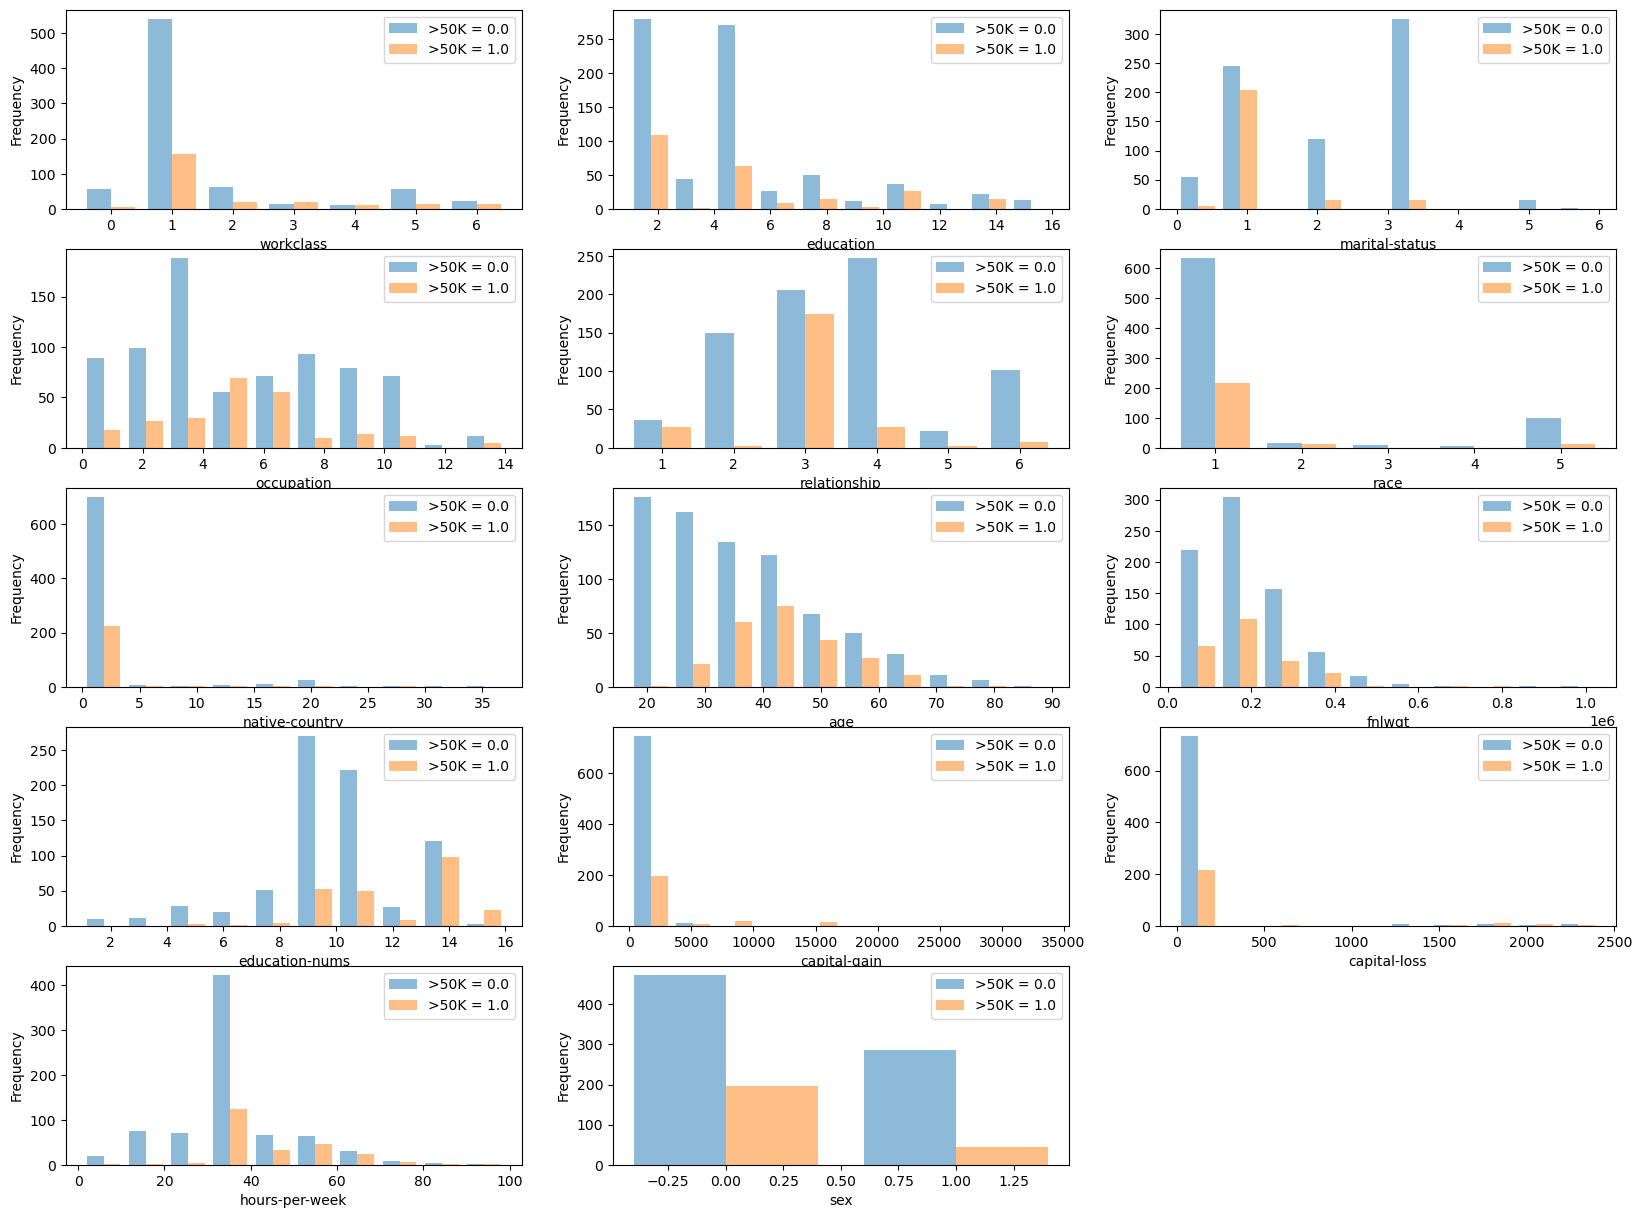

In [29]:
plt.figure()
#========================================
# part a: plot histograms of each feature    
print('Plotting...')
plot_histograms (X, y, Xnames=Xnames, yname=yname)

In [30]:
#========================================
# train Majority Vote classifier on data
print('Classifying using Majority Vote...')
clf = MajorityVoteClassifier() # create MajorityVote classifier, which includes all model parameters
clf.fit(X, y)                  # fit training data using the classifier
y_pred = clf.predict(X)        # take the classifier and run it on the training data
train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
print('\t-- training error: %.3f' % train_error)

Classifying using Majority Vote...
	-- training error: 0.240


In [31]:
### ========== TODO : START ========== ###
# part b: evaluate training error of Random classifier
rclf = RandomClassifier()
rclf.fit(X,y)
y_pred = rclf.predict(X)
train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
print('\t-- training error: %.3f' % train_error)
### ========== TODO : END ========== ###

	-- training error: 0.385


In [32]:
### ========== TODO : START ========== ###
# part c: evaluate training error of Decision Tree classifier
dtclf = DecisionTreeClassifier(criterion = "entropy")
dtclf.fit(X,y)
y_pred = dtclf.predict(X)
train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
print('criterion = entropy\t-- training error: %.3f' % train_error)
### ========== TODO : END ========== ###

criterion = entropy	-- training error: 0.000


In [33]:
### ========== TODO : START ========== ###
# part d: evaluate training error of k-Nearest Neighbors classifier
# use k = 3, 5, 7 for n_neighbors

for k in range (3, 9, 2):
    Knclf = KNeighborsClassifier(n_neighbors = k)
    Knclf.fit(X,y)
    y_pred = Knclf.predict(X)
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print(f'k = {k}\t-- training error: %.3f' % train_error)
    
### ========== TODO : END ========== ###

k = 3	-- training error: 0.153
k = 5	-- training error: 0.195
k = 7	-- training error: 0.213


In [34]:
### ========== TODO : START ========== ###
# part e: evaluate training error of Logistic Regression
# use lambda_ = 0.1, 1, 10 for n_neighbors
# Note: Make sure you initialize your classifier with the appropriate parameters: random_state=0 and max_iter=1000, using the default solver is fine.
for lambda_value in [0.1, 1, 10]:
    lrclf = LogisticRegression(random_state=0, max_iter=1000, C=1/lambda_value)
    lrclf.fit(X, y)
    y_pred = lrclf.predict(X)
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print(f'lambda = {lambda_value} -- training error: {train_error:.3f}')

    
### ========== TODO : END ========== ###

lambda = 0.1 -- training error: 0.208
lambda = 1 -- training error: 0.208
lambda = 10 -- training error: 0.213


In [46]:
### ========== TODO : START ========== ###
# part f: use cross-validation to compute average training and validation error of classifiers
print('Investigating various classifiers...')

print('Classifying using Random Classifier...')
clf = RandomClassifier() # create Random Classifier, which includes all model parameters
clf.fit(X, y)                  # fit training data using the classifier
rc_train_error, rc_val_error, rc_f1_score = error(clf, X, y, 100, 0.15)
print('\t-- training error: %.3f' % rc_train_error)
print('\t-- validation error: %.3f' % rc_val_error)
print('\t-- F1 score: %.3f' % rc_f1_score)

print('Classifying using Decision Tree Classifier...')
clf = DecisionTreeClassifier(criterion='entropy', random_state=0)
clf.fit(X, y)
rc_train_error, rc_val_error, rc_f1_score = error(clf, X, y, 100, 0.15)
print('\t-- training error: %.3f' % rc_train_error)
print('\t-- validation error: %.3f' % rc_val_error)
print('\t-- F1 score: %.3f' % rc_f1_score)

print('Classifying using KNN Classifier...')
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X, y)
rc_train_error, rc_val_error, rc_f1_score = error(clf, X, y, 100, 0.15)
print('\t-- training error: %.3f' % rc_train_error)
print('\t-- validation error: %.3f' % rc_val_error)
print('\t-- F1 score: %.3f' % rc_f1_score)

print('Classifying using Logistic Regression Classifier...')
clf = LogisticRegression(random_state=0, max_iter=1000, C=1)
clf.fit(X, y)
rc_train_error, rc_val_error, rc_f1_score = error(clf, X, y, 100, 0.15)
print('\t-- training error: %.3f' % rc_train_error)
print('\t-- validation error: %.3f' % rc_val_error)
print('\t-- F1 score: %.3f' % rc_f1_score)

### ========== TODO : END ========== ###

Investigating various classifiers...
Classifying using Random Classifier...
	-- training error: 0.361
	-- validation error: 0.380
	-- F1 score: 0.620
Classifying using Decision Tree Classifier...
	-- training error: 0.000
	-- validation error: 0.207
	-- F1 score: 0.793
Classifying using KNN Classifier...
	-- training error: 0.198
	-- validation error: 0.293
	-- F1 score: 0.707
Classifying using Logistic Regression Classifier...
	-- training error: 0.212
	-- validation error: 0.220
	-- F1 score: 0.780


Finding the best k...


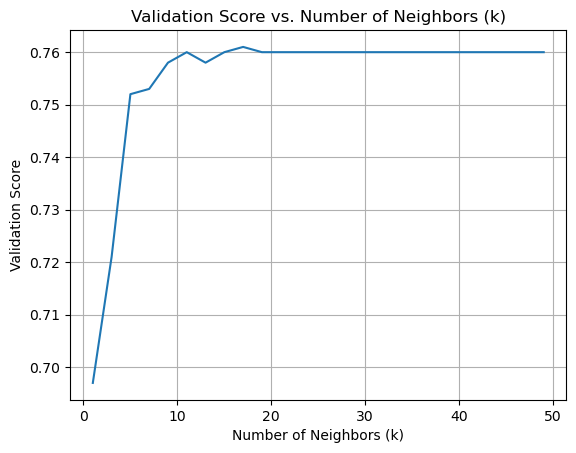

The best value of k is 17 with a maximum validation score of 0.7609999999999999


In [44]:
### ========== TODO : START ========== ###
# part g: use 5-fold cross-validation to find the best value of k for k-Nearest Neighbors classifier
input_k = []
validation_scores = []

input_k = np.arange(1, 50, 2)
print('Finding the best k...')
for i in input_k:
    Knclf = KNeighborsClassifier(n_neighbors=i)
    scores = cross_val_score(Knclf, X, y)  # 5-fold cross-validation is the default for cross_val_score
    mean_validation_score = scores.mean() 
    validation_scores.append(mean_validation_score)

plt.plot(input_k, validation_scores)
plt.title('Validation Score vs. Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Validation Score')
plt.grid(True)
plt.show()

maximum_score = max(validation_scores)
best_k = input_k[validation_scores.index(maximum_score)]

print(f"The best value of k is {best_k} with a maximum validation score of {maximum_score}")
    
### ========== TODO : END ========== ###

Investigating depths...


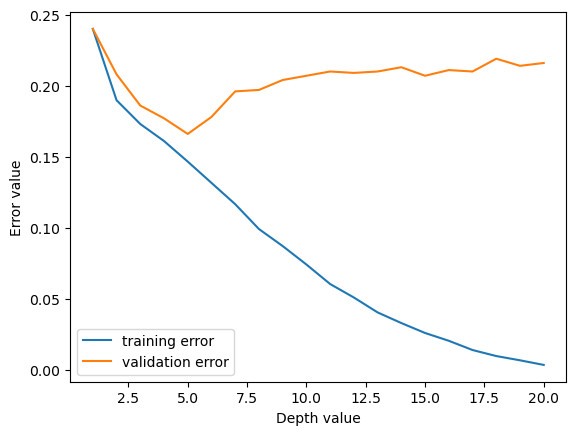

Best depth: 5


In [54]:
### ========== TODO : START ========== ###
# part h: investigate decision tree classifier with various depths
print('Investigating depths...')
depth_limit = np.arange(1, 21)
training_error = []
validation_error = []
for depth in depth_limit:
    DTclf = DecisionTreeClassifier(criterion='entropy', random_state = 0, max_depth=depth)
    scores = cross_validate(DTclf, X, y, return_train_score = True) #Default is 5-fold cross validation
    training_score = np.array(scores['train_score'])
    testing_score = np.array(scores['test_score'])
    mean_training_score = training_score.mean()
    mean_testing_score = testing_score.mean()
    mean_training_error = 1 - mean_training_score
    mean_testing_error = 1 - mean_testing_score
    training_error.append(mean_training_error)
    validation_error.append(mean_testing_error)

plt.plot(depth_limit, training_error, label = "training error")
plt.plot(depth_limit, validation_error, label = "validation error")
plt.xlabel("Depth value")
plt.ylabel("Error value")
plt.legend()
plt.show()
minimum_validation_error = min(validation_error)
best_depth = depth_limit[validation_error.index(minimum_validation_error)]
print("Best depth:" , best_depth)
### ========== TODO : END ========== ###

In [ ]:
print('Done')